<a href="https://colab.research.google.com/github/Elazarbsh/DL-Final-Project/blob/main/final_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports


In [16]:
import os
import cv2
import numpy as np
import tensorflow as tf
import itertools

import keras
from keras.datasets import cifar10
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, Conv2D, MaxPool2D, Flatten, MaxPooling2D
from tensorflow.keras.optimizers import Adam, SGD


from IPython.display import display
from keras.preprocessing.image import array_to_img
from keras.callbacks import TensorBoard

from time import strftime

from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt

# Constants

set the label names, the size and shape of the input and the size of the validation set.

In [2]:
LOG_DIR = 'tensorboard_cifar_logs/'

DICT = {
    'hotdog': 0,
    'hamburger': 1,
    'pizza': 2
}

LABEL_NAMES = ['Hotdog', 'Hamburger', 'Pizza']
IMAGE_WIDTH = 128
IMAGE_HEIGHT = 128
IMAGE_PIXELS = IMAGE_WIDTH * IMAGE_HEIGHT
COLOR_CHANNELS = 3
TOTAL_INPUTS = IMAGE_PIXELS * COLOR_CHANNELS
NR_CLASSES = 3

VALIDATION_SIZE = 100


# Download the dataset

In [11]:
!gdown https://drive.google.com/uc?id=1QiWB25GQ0-CPnkRYXKNibNEUwpajZYR1 -O dataset.zip


Downloading...
From: https://drive.google.com/uc?id=1QiWB25GQ0-CPnkRYXKNibNEUwpajZYR1
To: /content/dataset.zip
100% 446M/446M [00:04<00:00, 111MB/s]


In [ ]:
!unzip dataset.zip -d .


In [ ]:
#!unzip drive/MyDrive/dataset.zip -d .


# Load Data

load the training and testing sets into the corresponding classes and resizing the images.

In [ ]:
# Load data
def load_data(data_type='train', class_name='hot_dog'):
  instances = []
  classes = []
  for filepath in os.listdir(f'{data_type}/{class_name}'):
    read_image = cv2.imread(f'{data_type}/{class_name}/{format(filepath)}', 1)
    read_image = cv2.cvtColor(read_image, cv2.COLOR_BGR2RGB)
    resized_image = cv2.resize(read_image, (IMAGE_WIDTH, IMAGE_HEIGHT))

    instances.append(resized_image)
    classes.append(DICT[class_name])
  return (instances, classes)

In [ ]:
# Load and merge training data
X_train_hd, y_train_hd = load_data(data_type='train', class_name='hotdog')
X_train_h, y_train_h = load_data(data_type='train', class_name='hamburger')
X_train_p, y_train_p = load_data(data_type='train', class_name='pizza')

X_train = np.array(X_train_hd + X_train_h + X_train_p)
y_train = np.array(y_train_hd + y_train_h + y_train_p)

# Load and merge testing data
X_test_hd, y_test_hd = load_data(data_type='test', class_name='hotdog')
X_test_h, y_test_h = load_data(data_type='test', class_name='hamburger')
X_test_p, y_test_p = load_data(data_type='test', class_name='pizza')

X_test = np.array(X_test_hd + X_test_h + X_test_p)
y_test = np.array(y_test_hd + y_test_h + y_test_p)

# Preprocess Data

normalize every RGB value in each pixel.

In [ ]:
X_train, X_test = X_train / 255.0, X_test / 255.0

# Create validation dataset

In [ ]:
# Split the data
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.05, shuffle= True)
print(X_train.shape)
print(X_valid.shape)

(7097, 128, 128, 3)
(374, 128, 128, 3)


# Define the neural network using keras

this model worked best for us. view summary for details.

In [ ]:
model = Sequential()
model.add(Conv2D(128,3,padding="same", activation="relu", input_shape=(128,128,3)))
model.add(MaxPool2D())

model.add(Dropout(0.5))
model.add(Conv2D(64, 3, padding="same", activation="relu"))
model.add(MaxPool2D())

model.add(Dropout(0.5))
model.add(Conv2D(32, 3, padding="same", activation="relu"))
model.add(MaxPool2D())

model.add(Dropout(0.5))
model.add(Conv2D(16, 3, padding="same", activation="relu"))
model.add(MaxPool2D())

model.add(Dropout(0.4))
model.add(Flatten())
model.add(Dense(8,activation="relu"))
model.add(Dense(3, activation="softmax"))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 128)     3584      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 64, 128)      0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 64, 64, 128)       0         
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 64)        73792     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 32, 32, 64)       0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 32, 32, 64)        0

In [ ]:
opt = Adam(lr=0.0001)
model.compile(optimizer = opt , loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True) , metrics = ['accuracy'])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


# Fit the model

the model is trained for 500 epochs with batch size of 64. early stopping is used to prevent overfitting.

In [ ]:
# Fit with early stopping and model checkpoint to save the best models. 
from keras.callbacks import EarlyStopping, ModelCheckpoint
# # patient early stopping
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=50)
# mc = ModelCheckpoint('models/model-{epoch:03d}-{accuracy:03f}-{val_accuracy:03f}.h5', monitor='val_loss', mode='min', verbose=1, save_best_only=True)
# # evaluate the model
history = model.fit(X_train,y_train,epochs = 500 , batch_size=64, validation_data = (X_valid, y_valid), callbacks=[es], verbose=1)

Epoch 1/500


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


111/111 [==============================] - 24s 109ms/step - loss: 1.1375 - accuracy: 0.3669 - val_loss: 1.0951 - val_accuracy: 0.3770
Epoch 2/500
111/111 [==============================] - 10s 90ms/step - loss: 1.0661 - accuracy: 0.4172 - val_loss: 1.0885 - val_accuracy: 0.3663
Epoch 3/500
111/111 [==============================] - 10s 90ms/step - loss: 1.0517 - accuracy: 0.4310 - val_loss: 1.0888 - val_accuracy: 0.3717
Epoch 4/500
111/111 [==============================] - 10s 91ms/step - loss: 1.0335 - accuracy: 0.4544 - val_loss: 1.0694 - val_accuracy: 0.5187
Epoch 5/500
111/111 [==============================] - 10s 91ms/step - loss: 0.9803 - accuracy: 0.5184 - val_loss: 1.0186 - val_accuracy: 0.5588
Epoch 6/500
111/111 [==============================] - 10s 91ms/step - loss: 0.9340 - accuracy: 0.5494 - val_loss: 0.9739 - val_accuracy: 0.5374
Epoch 7/500
111/111 [==============================] - 10s 91ms/step - loss: 0.8913 - accuracy: 0.5732 - val_loss: 0.9619 - val_accuracy: 0.4

# Save the model

saving the trained model.

In [ ]:
model.save('our_model.h5')

In [ ]:
from tensorflow.keras.models import load_model
our_model = load_model('our_model.h5')

In [ ]:
# bash
!pip install tensorflowjs
!tensorflowjs_converter --input_format=keras our_model.h5 .

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 81 kB 5.1 MB/s 
     |████████████████████████████████| 1.0 MB 18.8 MB/s 
     |████████████████████████████████| 40 kB 6.0 MB/s 
     |████████████████████████████████| 180 kB 53.7 MB/s 
     |████████████████████████████████| 145 kB 49.9 MB/s 
     |████████████████████████████████| 217 kB 48.5 MB/s 
     |████████████████████████████████| 51 kB 6.3 MB/s 
     |████████████████████████████████| 76 kB 6.1 MB/s 
  Created wheel for jax: filename=jax-0.3.16-py3-none-any.whl size=1197715 sha256=684931b1dfaf72f580494039166d86f5505d7dab9b116b0922ce8b22086b780f
  Stored in directory: /root/.cache/pip/wheels/b9/0d/a2/2091279bf29b90a2211a271f6f006ef13a656211a9e69ba1e3
Successfully built jax
  Attempting uninstall: jax
    Found existing installation: jax 0.3.14
    Uninstalling jax-0.3.14:
      Successfully uninstalled jax-0.3.14
  Attempting uninstall: p

In [ ]:
x = X_test[0]
x = np.expand_dims(x, axis=0)
x.shape

(1, 128, 128, 3)

In [ ]:
our_model.predict(x)

array([[0.53091115, 0.46410188, 0.00498694]], dtype=float32)

# Evaluating the model

using the test set to evaluate the model



In [ ]:
test_loss, test_accuracy = our_model.evaluate(X_test, y_test)
print(f'Test loss is {test_loss:0.3} and test accuracy is {test_accuracy:0.1%}')

/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


70/70 [==============================] - 42s 598ms/step - loss: 0.3645 - accuracy: 0.8643
Test loss is 0.365 and test accuracy is 86.4%


# Confusion matrix

In [ ]:
predict_x=our_model.predict(X_test) 
classes_x=np.argmax(predict_x,axis=1)
conf_matrix = confusion_matrix(y_true=y_test, y_pred=classes_x)

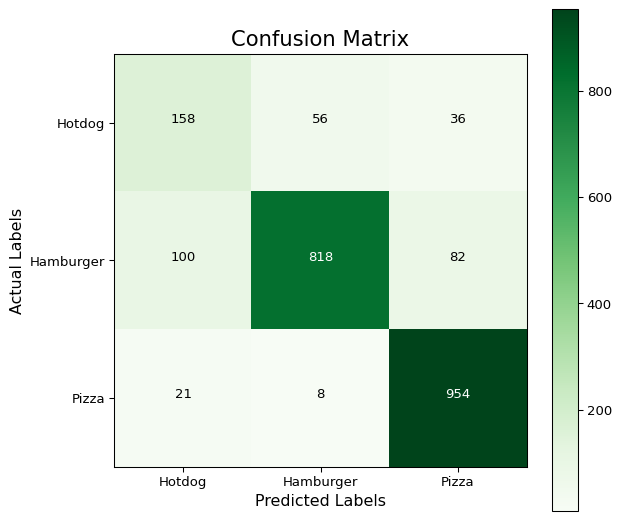

In [ ]:
plt.figure(figsize=(7,7), dpi=95)
plt.imshow(conf_matrix, cmap=plt.cm.Greens)

plt.title('Confusion Matrix', fontsize=16)
plt.ylabel('Actual Labels', fontsize=12)
plt.xlabel('Predicted Labels', fontsize=12)

tick_marks = np.arange(NR_CLASSES)
plt.yticks(tick_marks, LABEL_NAMES)
plt.xticks(tick_marks, LABEL_NAMES)

plt.colorbar()

for i, j in itertools.product(range(nr_rows), range(nr_cols)):
    plt.text(j, i, conf_matrix[i, j], horizontalalignment='center',
            color='white' if conf_matrix[i, j] > conf_matrix.max()/2 else 'black')
    

plt.show()

In [ ]:
recall = np.diag(conf_matrix) / np.sum(conf_matrix, axis=1)
recall

array([0.632     , 0.818     , 0.97049847])

In [ ]:
precision = np.diag(conf_matrix) / np.sum(conf_matrix, axis=0)
precision

array([0.56630824, 0.92743764, 0.88992537])

In [ ]:
avg_recall = np.mean(recall)
print(f'Model recall score is {avg_recall:.2%}')

Model recall score is 80.68%


In [ ]:
avg_precision = np.mean(precision)
print(f'Model precision score is {avg_precision:.2%}')

Model precision score is 79.46%


#Using The Model

we made a simple web app the utilizes our trained model for demonstration purposes. the app takes an image and outputs the prediction and accuracy of the prediction.

https://thawing-waters-69155.herokuapp.com/